# Etudes de phénomènes aérospatiaux non identifiés (PAN) de 1910 à 2014

# Communiquez vos résultats - partie 5
# Analyse des phénomènes avec les données météo

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importation-et-lecture-du-fichier-météo/UFO_shape" data-toc-modified-id="Importation-et-lecture-du-fichier-météo/UFO_shape-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importation et lecture du fichier météo/UFO_shape</a></span></li><li><span><a href="#Analyses-des-variables" data-toc-modified-id="Analyses-des-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyses des variables</a></span><ul class="toc-item"><li><span><a href="#Analyse-univariée" data-toc-modified-id="Analyse-univariée-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Analyse univariée</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-variables-quantitatives" data-toc-modified-id="Analyse-des-variables-quantitatives-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Analyse des variables quantitatives</a></span></li><li><span><a href="#Analyse-des-variables-qualitatives" data-toc-modified-id="Analyse-des-variables-qualitatives-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Analyse des variables qualitatives</a></span></li></ul></li><li><span><a href="#Analyses-bivariées" data-toc-modified-id="Analyses-bivariées-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Analyses bivariées</a></span><ul class="toc-item"><li><span><a href="#Test-d'ANOVA" data-toc-modified-id="Test-d'ANOVA-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Test d'ANOVA</a></span></li><li><span><a href="#Test-du-chi2" data-toc-modified-id="Test-du-chi2-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Test du chi2</a></span></li></ul></li></ul></li><li><span><a href="#Etude-des-UFO_shape" data-toc-modified-id="Etude-des-UFO_shape-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Etude des <code>UFO_shape</code></a></span><ul class="toc-item"><li><span><a href="#Etude-temporelle-des-phénomènes" data-toc-modified-id="Etude-temporelle-des-phénomènes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Etude temporelle des phénomènes</a></span></li><li><span><a href="#Etude-géographique-des-phénomènes" data-toc-modified-id="Etude-géographique-des-phénomènes-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Etude géographique des phénomènes</a></span></li></ul></li></ul></div>

In [1]:
%load_ext pycodestyle_magic

%pycodestyle_on

Importation des librairies nécessaires à l'exécution du code

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly
import plotly.express as px
import json
from datetime import datetime
import re
import datetime

# Librairies statistiques
from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy.stats import ks_2samp

# Librairies visualisation
from folium import Choropleth
from folium.plugins import HeatMap
from urllib.request import urlopen

import plotly.figure_factory as ff
import plotly.io as pio
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode, download_plotlyjs
# jupyter set up
init_notebook_mode(connected=True)

In [2]:
#  version de pandas
print(f'version pandas : {pd.__version__}')
#  version de numpy
print(f'version numpy : {np.__version__}')
#  version de folium
print(f'version folium : {folium.__version__}')
# version de plotly
print(f'version plotly : {plotly.__version__}')
#  version de plotly express
# print(f'version plotly express : {px.__version__}')

version pandas : 1.1.3
version numpy : 1.19.2
version folium : 0.12.1
version plotly : 4.14.3


In [3]:
ENCODAGE = 'UTF-8'

In [4]:
TEMPLATE = 'plotly_dark'

In [5]:
COLORS = {'Canada':'#fdca26',
          'United Kingdom':'#35b779',
          'USA':'#0d0887'}

In [6]:
COLOR_EVOLUTION = 'Plasma_r'
COLOR_UFO_SHAPE = px.colors.sequential.Mint
COLOR_UFO_DURATION = px.colors.sequential.Blues

In [7]:
sns.set(style="darkgrid")

In [8]:
def ks_2samp_test(col, df):
    """Test de Kolmogorov-Smirnov 
    Test d'adéquation à une loi normale.
    
    Parameters
    ----------
    col : variable à tester
    df : dataset étudié
    
    Le seuil alpha est fixé à 0.05
    
    Returns
    -------
    Un message indiquant la normalité ou non de la variable
    """
    
    alpha = 0.05
    stat, p_value = ks_2samp(df[col],
                             list(np.random.normal(np.mean(df[col]),
                                                   np.std(df[col]),
                                                   1000)
                                 )
                            )
    print(f'p_value :{p_value}')
    
    if p_value < alpha :
        return(f'HO rejetée, la variable {col} ne suit pas une loi normale')
    else :
        return (f'HO ne peut pas être rejetée, la variable {col} suit une loi NORMALE')

In [9]:
def eta_squared(df, X, Y):
    """Calcul de l'éta carré.
    Permet de calculer le rapport de corrélation.
        
    Parameters
    ----------
    df : dataset
    X : variable qualitative
    Y : variable quantitative
    
    Returns
    -------
    rapport de corrélation
    SCE/SCT    
    """
    
    sous_echantillon = df.copy()
    x = sous_echantillon[X]
    y = sous_echantillon[Y]
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x == classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

## Importation et lecture du fichier météo/UFO_shape

Dataframe `df_ufo_weather`

In [10]:
df_ufo_weather = pd.read_csv("weather_clean.csv",
                             encoding=ENCODAGE,
                             parse_dates=['reportedTimestamp',
                                          'eventDate',
                                          'eventTime'])
df_ufo_weather.head(2)

,reportedTimestamp,eventDate,eventTime,UFO_shape,duration,witnesses,weather,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04 04:02:00,1977-03-31,1900-01-01 23:46:00,circle,4,1,rain,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22 02:06:00,1982-11-15,1900-01-01 22:04:00,disk,4,1,partly cloudy,52.664913,-1.034894,Y,Y,N,explained


Description statistique du dataframe

In [11]:
df_ufo_weather.describe()

,duration,witnesses,latitude,longitude
count,17998.000000,17998.000000,17998.000000,17998.000000
mean,50.519947,5.513335,37.768633,-87.032628
std,28.688729,2.882738,10.074846,38.838552
min,1.000000,1.000000,-46.163992,-169.541667
25%,26.000000,3.000000,33.990833,-111.840556
50%,51.000000,5.000000,38.901389,-87.841806
75%,75.000000,8.000000,42.271111,-79.121667
max,100.000000,10.000000,70.416667,178.441900


Dimension du dataset

Dimension du dataset

In [12]:
df_ufo_weather.shape

(17998, 13)

Pour une future analyse temporelle, on va créer des colonnes supplémentaires

Création d'une colonne `year` pour les années

In [13]:
df_ufo_weather['year'] = df_ufo_weather.reportedTimestamp.dt.year

Création d'une colonne `month` pour les mois

In [14]:
df_ufo_weather['month'] = df_ufo_weather.reportedTimestamp.dt.month

Création d'une colonne `day` pour les jours

In [15]:
# Création de la colonne "day"
df_ufo_weather['day'] = df_ufo_weather.reportedTimestamp.dt.weekday

Création d'une colonne `hour` pour les heures

In [16]:
df_ufo_weather['hour'] = df_ufo_weather.reportedTimestamp.dt.hour

Vérification du type des variables

In [17]:
df_ufo_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17998 entries, 0 to 17997
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   reportedTimestamp  17998 non-null  datetime64[ns]
 1   eventDate          17998 non-null  datetime64[ns]
 2   eventTime          17998 non-null  datetime64[ns]
 3   UFO_shape          17998 non-null  object        
 4   duration           17998 non-null  int64         
 5   witnesses          17998 non-null  int64         
 6   weather            17998 non-null  object        
 7   latitude           17998 non-null  float64       
 8   longitude          17998 non-null  float64       
 9   sighting           17998 non-null  object        
 10  physicalEvidence   17998 non-null  object        
 11  contact            17998 non-null  object        
 12  researchOutcome    17998 non-null  object        
 13  year               17998 non-null  int64         
 14  month 

Importation d'un fichier répertoriant la localisation des **aéroports mondiaux** pour les faire figurer dans une carte

In [22]:
df_airport = pd.read_csv("osm-world-airports.csv",sep=';',
                         encoding=ENCODAGE, engine='python')

In [23]:
df_airport = df_airport[["Country", "Country code", "Name", "Geo Point"]]

In [24]:
df_airport.head(2)

,Country,Country code,Name,Geo Point
0,United States of America,US,Las Cruces International Airport,"32.286877,-106.9220857"
1,United States of America,US,Sawyer International Airport,"46.349652,-87.3871745"


Description du fichier des aéroports

In [25]:
df_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country       615 non-null    object
 1   Country code  613 non-null    object
 2   Name          662 non-null    object
 3   Geo Point     662 non-null    object
dtypes: object(4)
memory usage: 20.8+ KB


Création des colonnes `latitude` et `longitude` à partir de `Geo Point`

In [26]:
df_airport['latitude'] = df_airport['Geo Point'].str.split(',', 1).str[0]
df_airport['latitude'] = df_airport['latitude'].astype(float)
df_airport['longitude'] = df_airport['Geo Point'].str.split(',', 1).str[1]
df_airport['longitude'] = df_airport['longitude'].astype(float)

Vérification des types des variables

In [27]:
df_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       615 non-null    object 
 1   Country code  613 non-null    object 
 2   Name          662 non-null    object 
 3   Geo Point     662 non-null    object 
 4   latitude      662 non-null    float64
 5   longitude     662 non-null    float64
dtypes: float64(2), object(4)
memory usage: 31.2+ KB


## Analyses des variables

###  Analyse univariée

In [18]:
df_ufo_weather.tail(2)

,reportedTimestamp,eventDate,eventTime,UFO_shape,duration,witnesses,weather,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome,year,month,day,hour
17996,1971-07-23 13:22:00,1971-07-18,1900-01-01 13:59:00,square,28,10,snow,35.385833,-94.398333,Y,N,N,unexplained,1971,7,4,13
17997,2008-11-28 02:19:00,2008-11-27,1900-01-01 15:37:00,circle,38,10,snow,29.883056,-97.941111,Y,N,N,explained,2008,11,4,2


Type des variables

In [19]:
df_ufo_weather.dtypes

reportedTimestamp    datetime64[ns]
eventDate            datetime64[ns]
eventTime            datetime64[ns]
UFO_shape                    object
duration                      int64
witnesses                     int64
weather                      object
latitude                    float64
longitude                   float64
sighting                     object
physicalEvidence             object
contact                      object
researchOutcome              object
year                          int64
month                         int64
day                           int64
hour                          int64
dtype: object

#### Analyse des variables quantitatives

Convertion des `Geo Point` en float

Description statistique de la variable `duration`

In [20]:
df_ufo_weather['duration'].describe()

count    17998.000000
mean        50.519947
std         28.688729
min          1.000000
25%         26.000000
50%         51.000000
75%         75.000000
max        100.000000
Name: duration, dtype: float64

Distribution de `duration` en fonction des PAN

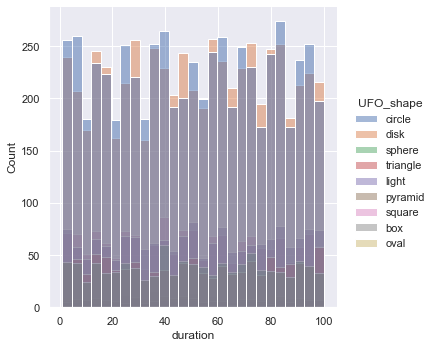

In [21]:
sns.displot(df_ufo_weather,
            x="duration",
            hue='UFO_shape')
plt.show()

Etude de la distribution des variables quantitatives

variable : duration


<Figure size 432x288 with 0 Axes>

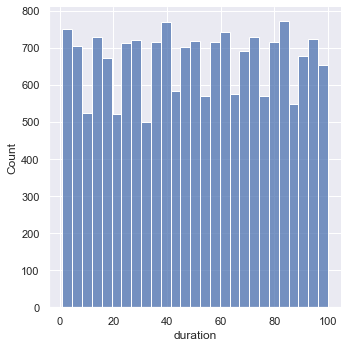

variable : witnesses


<Figure size 432x288 with 0 Axes>

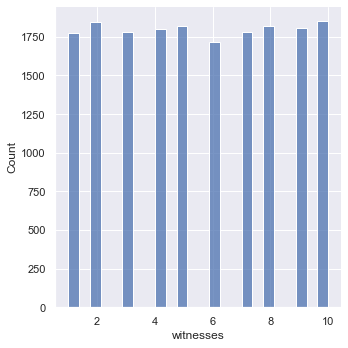

variable : year


<Figure size 432x288 with 0 Axes>

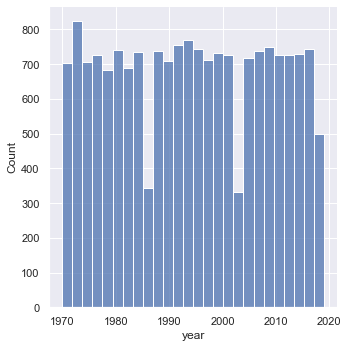

variable : month


<Figure size 432x288 with 0 Axes>

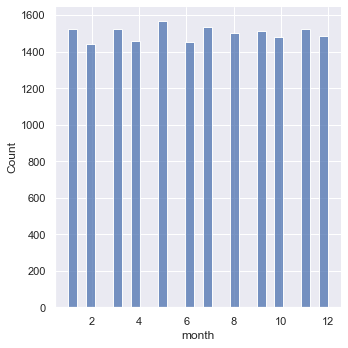

variable : day


<Figure size 432x288 with 0 Axes>

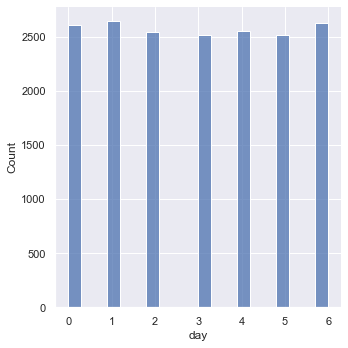

variable : hour


<Figure size 432x288 with 0 Axes>

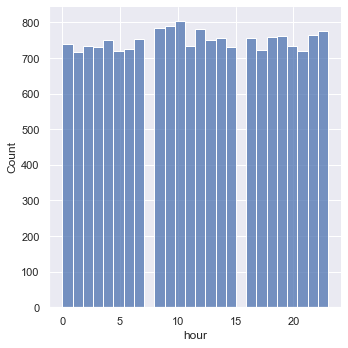

In [28]:
for col in df_ufo_weather.select_dtypes('int64'):
    plt.figure()
    print(f'variable : {col}')    
    sns.displot(df_ufo_weather[col])
    plt.show()

Les données sont nettoyées. Il n'y a pas d'outliers  
Les années sont comprises entre 1970 et 2019  
La variable `duration` est comprise entre 0 et 100.

Visualisation de la variable "witnesses"

<AxesSubplot:ylabel='witnesses'>

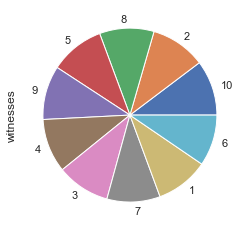

In [29]:
df_ufo_weather["witnesses"].value_counts().plot.pie()

#### Analyse des variables qualitatives

Items des différentes variables

In [30]:
for col in df_ufo_weather.select_dtypes('O'):
    print(f'{col:-<30}{df_ufo_weather[col].unique()}')

UFO_shape---------------------['circle' 'disk' 'sphere' 'triangle' 'light' 'pyramid' 'square' 'box'
 'oval']
weather-----------------------['rain' 'partly cloudy' 'clear' 'mostly cloudy' 'fog' 'snow' 'stormy']
sighting----------------------['Y']
physicalEvidence--------------['N' 'Y']
contact-----------------------['N' 'Y']
researchOutcome---------------['explained' 'probable' 'unexplained']


Distribution des différentes variables

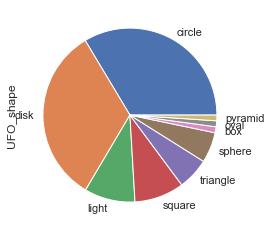

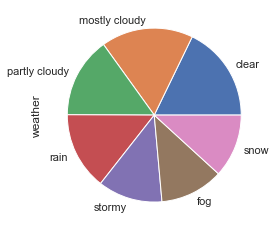

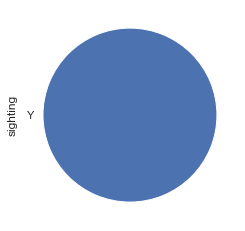

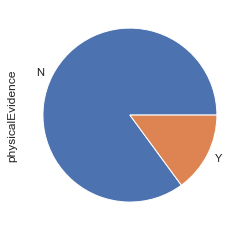

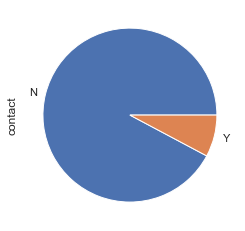

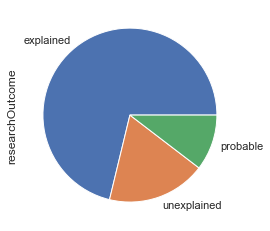

In [31]:
for col in df_ufo_weather.select_dtypes('O'):
    plt.figure()
    df_ufo_weather[col].value_counts().plot.pie()

Suppression de la variable "sighting" car n'a qu'une même valeur et donc est inutile

In [32]:
df_ufo_weather.drop("sighting", axis=1, inplace=True)

Dataframe `df_ufo_weather`

In [34]:
df_ufo_weather.head(2)

,reportedTimestamp,eventDate,eventTime,UFO_shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome,year,month,day,hour
0,1977-04-04 04:02:00,1977-03-31,1900-01-01 23:46:00,circle,4,1,rain,47.329444,-122.578889,N,N,explained,1977,4,0,4
1,1982-11-22 02:06:00,1982-11-15,1900-01-01 22:04:00,disk,4,1,partly cloudy,52.664913,-1.034894,Y,N,explained,1982,11,0,2


Dimension du dataset

In [33]:
df_ufo_weather.shape

(17998, 16)

Répartition de la détermination de la nature des phénomènes

In [35]:
df_ufo_weather_gpe = df_ufo_weather.groupby(['researchOutcome']).agg(
    count_UFO_shape=('UFO_shape', 'count')
).reset_index()

In [36]:
df_ufo_weather_gpe

,researchOutcome,count_UFO_shape
0,explained,12820
1,probable,1870
2,unexplained,3308


In [37]:
# Colors
colors = ['#0d0887', '#bd3786', '#fb9f3a', '#f0f921']

# Text
layout = go.Layout(title="Répartition de la détermination de la nature des phénomènes<br>"
                   "<sup>(de 1970 à 2019)</sup>",
                   font=dict(family='Arial',
                             size=14,
                             ),
                   template=TEMPLATE)

# Graph
fig = go.Figure(data=[go.Pie(labels=['expliqué', 'inexpliqué', 'probable'],
                             values=[12820, 3308, 1870])],                
                layout=layout)

# Text
fig.update_traces(hoverinfo='label+percent',
                  textfont_size=12,
                  textinfo='label+percent',
                  pull=[0, 0.1, 0.1, 0.1],
                  marker=dict(colors=colors,
                              line=dict(color='#FFFFFF',
                                        width=0))
                  )

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.005,
                        xanchor='center', yanchor='top',
                        text="Source: fichier nettoyé df_ufo_weather.csv<br>"
                        "  (fichier original: https://www.kaggle.com/dwarika/ufo-datasets-the-truth-is-out-there)",


                        font=dict(family='Arial',
                                  size=14,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)
# fig.show()

Les phénomènes expliqués sont majoritaires.

Export du fichier en csv

In [38]:
df_ufo_weather.to_csv("df_ufo_weather.csv", index=False, encoding=ENCODAGE)

### Analyses bivariées

#### Test d'ANOVA

**Le nombre de phénomènes est-il dépendant ou non de la météo ?**

In [39]:
df_ufo_weather.head(2)

,reportedTimestamp,eventDate,eventTime,UFO_shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome,year,month,day,hour
0,1977-04-04 04:02:00,1977-03-31,1900-01-01 23:46:00,circle,4,1,rain,47.329444,-122.578889,N,N,explained,1977,4,0,4
1,1982-11-22 02:06:00,1982-11-15,1900-01-01 22:04:00,disk,4,1,partly cloudy,52.664913,-1.034894,Y,N,explained,1982,11,0,2


On crée un dataframe `df_weater_gp` qui rassemble le type de météo avec le nombre de phénomènes par forme

In [40]:
df_weater_gp = df_ufo_weather.groupby('weather').agg(
    count_ufo=('UFO_shape', 'value_counts')
).reset_index()

In [41]:
df_weater_gp.head(2)

,weather,UFO_shape,count_ufo
0,clear,circle,1103
1,clear,disk,1100


Création de groupes pour l'ANOVA

In [42]:
gp_rain = df_weater_gp[df_weater_gp.weather == 'rain']['count_ufo']

In [43]:
gp_clear = df_weater_gp[df_weater_gp.weather == 'clear']['count_ufo']

In [44]:
gp_mostly_cloudy = df_weater_gp[df_weater_gp.weather == 'mostly cloudy']['count_ufo']

Tests d'hypothèse  
H0 : les moyennes des groupes sont égales  
H1 : au moins une moyenne des groupes est différentes  
seuil alpha : 0.05

In [45]:
# Stats f_oneway functions takes the groups as input
# Returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(gp_rain,
                                gp_clear,
                                gp_mostly_cloudy
                                )
print(f'f_value {fvalue}, p_value : {pvalue}')

f_value 0.07721169469150592, p_value : 0.9259228592077596


La p_value est significativement plus grande que le seuil de 5% choisi.  
L'hypothèse H0 d'égalité des moyennes ne peut pas être rejetée  
La **météo** n'influe pas sur le **nombre de phénomènes observés**

Etude des corrélations avec l'éta2

In [46]:
# X : var qual
# Y : var quant
v_quanti = ['duration', 'longitude', 'latitude']
for variable in v_quanti:
    print(f'eta_squared {variable} :', eta_squared(df_ufo_weather, 'weather', variable))

eta_squared duration : 0.0002785426191314648
eta_squared longitude : 0.0005859307482547958
eta_squared latitude : 0.0002090853354756164


Il n'y a pas de corrélation entre la météo et les variables quantitatives

#### Test du chi2

**Quelles sont les variables qui influent sur la forme des UFO (`UFO_shape`)?**

Test du chi2 sur les variables qualitatives

In [47]:
df_ufo_weather.select_dtypes('O').columns

Index(['UFO_shape', 'weather', 'physicalEvidence', 'contact',
       'researchOutcome'],
      dtype='object')

Tests d'hypothèses:

H0 : variables indépendantes  

H1 : variables dépendantes  

seuil alpha de 0.05%

In [48]:
# variables qualitatives :
quali = ['weather', 'hour', 'month', 'year', 'day']

for variable in quali:
    temp = pd.crosstab(df_ufo_weather['UFO_shape'], df_ufo_weather[variable])
    _, p_value, _, _ = chi2_contingency(temp)
    display(temp)
    print('p-value du test de chi2 :', p_value)

weather,clear,fog,mostly cloudy,partly cloudy,rain,snow,stormy
UFO_shape,,,,,,,
box,22,0,21,78,70,2,7
circle,1103,731,1061,823,786,751,792
disk,1100,789,1029,787,722,753,740
light,298,186,273,281,272,190,199
oval,27,0,30,60,72,7,3
pyramid,14,0,22,70,73,3,7
sphere,164,127,181,173,166,103,106
square,302,183,283,255,239,201,199
triangle,176,107,179,176,204,111,109


p-value du test de chi2 : 1.4629501808317024e-112


hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
UFO_shape,,,,,,,,,,,,,,,,,,,,,
box,9,6,11,12,7,8,10,3,9,9,...,6,10,6,9,15,5,3,8,5,7
circle,248,238,247,255,235,242,243,277,264,270,...,232,238,255,237,264,269,243,266,259,251
disk,222,254,238,223,258,233,240,228,266,259,...,250,253,262,237,243,236,249,230,252,256
light,68,61,63,61,78,74,50,78,69,71,...,91,61,75,80,73,73,64,69,87,61
oval,13,7,5,5,15,12,5,6,8,9,...,8,8,7,8,11,8,7,7,9,7
pyramid,8,7,8,7,5,9,8,6,6,6,...,12,12,5,9,10,8,7,1,10,7
sphere,45,37,34,54,36,32,52,44,48,34,...,44,47,33,35,48,45,40,41,29,61
square,69,63,76,69,79,64,76,76,68,81,...,67,63,71,55,57,82,69,60,77,70
triangle,57,43,53,45,38,47,42,35,47,50,...,47,39,42,52,37,37,52,38,37,56


p-value du test de chi2 : 0.3175187499794601


month,1,2,3,4,5,6,7,8,9,10,11,12
UFO_shape,,,,,,,,,,,,
box,17,13,20,14,21,10,15,18,18,25,18,11
circle,492,489,518,450,522,512,525,521,498,508,497,515
disk,515,456,488,495,552,470,498,519,478,484,482,483
light,156,155,155,147,133,126,146,114,139,130,152,146
oval,16,18,14,17,20,9,19,16,20,15,16,19
pyramid,19,9,11,22,14,18,8,18,21,15,23,11
sphere,94,82,71,78,85,69,93,77,86,97,96,92
square,133,126,148,158,125,142,141,133,154,117,154,131
triangle,79,91,99,79,95,95,89,85,100,86,88,76


p-value du test de chi2 : 0.21076919316308285


year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
UFO_shape,,,,,,,,,,,,,,,,,,,,,
box,4,5,5,2,1,3,2,8,4,5,...,4,5,4,8,5,3,1,5,7,2
circle,109,131,141,130,140,100,126,124,113,138,...,114,129,123,112,102,123,149,124,100,45
disk,131,109,113,144,116,111,109,132,117,113,...,118,124,127,118,112,137,111,114,116,53
light,27,37,54,44,34,26,38,34,26,20,...,37,32,35,34,37,39,36,40,36,14
oval,2,1,7,4,5,5,6,3,3,2,...,2,0,7,7,4,4,7,4,4,2
pyramid,2,2,4,4,2,1,4,1,4,6,...,3,7,2,5,4,2,7,5,5,1
sphere,23,16,23,23,28,19,20,12,16,21,...,21,20,17,28,15,23,20,17,24,8
square,36,24,41,32,43,32,34,36,28,31,...,37,32,33,26,45,35,27,33,38,12
triangle,23,21,31,22,23,16,15,21,21,14,...,20,22,16,23,16,23,24,20,19,13


p-value du test de chi2 : 0.24786129049560338


day,0,1,2,3,4,5,6
UFO_shape,,,,,,,
box,26,34,26,31,27,25,31
circle,878,897,806,865,854,866,881
disk,875,855,876,815,845,822,832
light,245,250,263,216,246,232,247
oval,44,31,29,19,21,24,31
pyramid,26,25,19,31,35,25,28
sphere,132,152,125,146,147,142,176
square,237,250,251,222,221,227,254
triangle,143,149,146,168,158,152,146


p-value du test de chi2 : 0.3588890218082196


weather / UFO_shape : la p_value est significativement inférieure au seuil de 5% choisi. L'hypothèse H0 d'indépendance est rejetée  
La varable `weather` est corrélée à la variable `UFO_shape`  
La **météo** influe donc sur la **forme des phénomènes**

En revanche, il n'y a pas de corrélation entre `UFO_shape` et les variables temporelles 

## Etude des `UFO_shape` 

Distribution du nombre `UFO_shape` en fonction de la météo

plotly

In [49]:
df_weater_gp.head(2)

,weather,UFO_shape,count_ufo
0,clear,circle,1103
1,clear,disk,1100


In [50]:
# Graph
fig = px.bar(df_weater_gp,
             y='count_ufo',
             x='weather',
             text='count_ufo',
             labels={'count_ufo': 'Nombre de phénomènes',
                     'weather': 'météo',
                     'UFO_shape': 'Forme du phénomène'},
             color='UFO_shape',
             barmode='group',
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textfont_size=14,                  
                  textposition='outside'
                  )
fig.update_layout(title='Fréquence des phénomènes en fonction de la météo',
                  showlegend=True)

# Axes
fig.update_xaxes(showgrid=True, ticks="outside")

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.14,
                        xanchor='center', yanchor='top',
                        text='Source: Fichier "weather_clean.csv"   ' +
                        '   Période: de 1970 à 2019',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

Les formes rondes sont les plus fréquentes quelque soit la météo  
Les formes triangulaires apparaissent mieux lors des temps de pluie  
Les formes carré et les lumières sont mieux perçues par temps dégagé  
Les formes plus complexes comme les boîtes, pyramides, ovales apparaissent mieux par temps couvert et/ou pluvieux mais sont rares par temps enneigés et orageux

On peut penser que des certains phénomènes répertoriés sont liés directement à des phénomènes météo

### Etude temporelle des phénomènes

Description statistique

In [51]:
df_ufo_weather.describe()

,duration,witnesses,latitude,longitude,year,month,day,hour
count,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000
mean,50.519947,5.513335,37.768633,-87.032628,1994.209190,6.505612,2.989832,11.545449
std,28.688729,2.882738,10.074846,38.838552,14.277416,3.447838,2.011430,6.892116
min,1.000000,1.000000,-46.163992,-169.541667,1970.000000,1.000000,0.000000,0.000000
25%,26.000000,3.000000,33.990833,-111.840556,1982.000000,4.000000,1.000000,6.000000
50%,51.000000,5.000000,38.901389,-87.841806,1994.000000,7.000000,3.000000,12.000000
75%,75.000000,8.000000,42.271111,-79.121667,2007.000000,9.000000,5.000000,18.000000
max,100.000000,10.000000,70.416667,178.441900,2019.000000,12.000000,6.000000,23.000000


Les années d'observations se répartissent entre 1970 et 2019

Distribution du nombre de phénomènes de 1970 à 2019

In [52]:
df_wea_year_gp = df_ufo_weather.groupby(["year"]).agg(
    count_ufo_shape=("UFO_shape",
                     "count")
).reset_index()

plotly

In [53]:
df_wea_year_gp.head(2)

,year,count_ufo_shape
0,1970,357
1,1971,346


Nombre de phénomènes de 1970 à 2019

In [54]:
# Graph
fig = px.bar(df_wea_year_gp,
             y='count_ufo_shape',
             x='year',
             text='count_ufo_shape',
             labels={'count_ufo_shape': 'Nombre de phénomènes',
                     'year': 'année'},
             color="count_ufo_shape",
             color_continuous_scale="Viridis_r",
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')
fig.update_layout(title='Nombre de phénomènes mondiaux<br>'
                  '<sup>de 1970 à 2019</sup>',
                  showlegend=True,
                  xaxis=dict(
                        showline=True,
                        showgrid=True,
                        showticklabels=True,
                        linecolor='rgb(204, 204, 204)',
                        linewidth=2,
                        ticks='outside',
                        tickfont=dict(
                            family='Arial',
                            size=12,
                            color='rgb(82, 82, 82)'
                        ),
                  ),
                  yaxis=dict(
                      showgrid=True,
                      zeroline=False,
                      showline=False,
                      showticklabels=True,
                      tickfont=dict(
                          family='Arial',
                          size=12,
                          color='rgb(82, 82, 82)'
                      ),
                  )
                  #                   plot_bgcolor='white'
                  )

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.14,
                        xanchor='center', yanchor='top',
                        text='Source: Fichier "weather_clean.csv"',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))


fig.update_layout(annotations=annotations)

fig.show()

Nombre de phénomènes de 1970 à 2019 (diagramme en ligne)

In [55]:
# Graph
fig = px.line(df_wea_year_gp,
              x='year',
              y='count_ufo_shape',
              labels={'count_ufo_shape': 'Nombre de phénomènes',
                      'year': 'année'},
              template=TEMPLATE)

# Text
fig.update_layout(title='Nombre de phénomènes mondiaux<br>'
                  '<sup>de 1970 à 2019</sup>',
                  showlegend=True)

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.14,
                        xanchor='center', yanchor='top',
                        text='Source: Fichier "weather_clean.csv"   ',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)
fig.show()

Baisse significatif des observations en 2019  
Maximun d'observation au début des année 70  
Dans l'ensemble, le nombre d'observations est constant

In [56]:
df_wea_loc_gp = df_ufo_weather.groupby('year').agg(
    count_ufo=('UFO_shape', 'count'),
    latitude=('latitude', 'mean'),
    longitude=('longitude', 'mean')
).reset_index()

### Etude géographique des phénomènes

Utilisation du fichier répertoriant la localisation des **aéroports mondiaux**

Dataframe `df_ufo_weather`

In [57]:
df_ufo_weather.head(2)

,reportedTimestamp,eventDate,eventTime,UFO_shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome,year,month,day,hour
0,1977-04-04 04:02:00,1977-03-31,1900-01-01 23:46:00,circle,4,1,rain,47.329444,-122.578889,N,N,explained,1977,4,0,4
1,1982-11-22 02:06:00,1982-11-15,1900-01-01 22:04:00,disk,4,1,partly cloudy,52.664913,-1.034894,Y,N,explained,1982,11,0,2


Dimension du dataset `df_ufo_weather`

In [58]:
df_ufo_weather.shape

(17998, 16)

Distribution mondiale des PAN

In [61]:
# Create map heatmap
m_weather = folium.Map(location=[40, -97.941111], zoom_start=2)
HeatMap(data=df_ufo_weather[['latitude',
                                'longitude']], radius=10).add_to(m_weather)

#  aéroports
# df_airport.apply(lambda row: folium.Marker([row["latitude"],
#                                                row["longitude"]],
#                                               icon=folium.Icon(icon="plane",
#                                                                color='blue'),
#                                               popup=row["Name"],
#                                               tooltip=row["Name"])
#                     .add_to(m_weather), axis=1)

m_weather
# Save map
# m_weather.save('m_weather.html')
